In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pylab as plt
from nltk.corpus import words
import pandas as pd
import sys
from scipy import spatial, stats
from collections import Counter, defaultdict
from matplotlib.colors import ListedColormap
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from numpy import dot
from numpy.linalg import norm
import operator
from statistics import mean, stdev
from scipy.stats import pearsonr, spearmanr
import math
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import json
import networkx as nx
import copy
import pickle
import matplotlib.colors
import geopandas
#from shapely.geometry import Point
import mapclassify

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

C:\Users\ditong\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Read in Data

### 1. year, socName, N posts, education

In [2]:
# JOB YEAR NPOSTS
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)
#             if pay != 'nan' and pay != 'nan\n':
#                 med_pay = pay.split('_')[1]
#                 if med_pay != 'nan' and float(med_pay) > 0:
#                     jyp[job][year] = float(med_pay)

### 2. socName - meta (ave. pay, ave. edu, 2-digits soc group)

In [3]:
oe={}
op={}
ocg={}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])
        ocg[job] = line_lst[3]

In [4]:
# SOC GROUP--6 digit SOC
go=defaultdict(lambda:set())
for o in ocg:
    go[ocg[o]].add(o)
len(ocg), len(go)

(838, 22)

### 3. year - socName - skill freq

In [5]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf

In [6]:
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            #print(job, year)
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]

In [7]:
len(jys), len(syj)

(831, 4915)

In [8]:
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)a. Large company year - socName - skill freq

In [9]:
# Large Company JOB-SKILL DATA
# without filtering the skills
lcyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/lc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    lcyjas[year][job][skill] = tfidf

# filter the defining skills
lcjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in lcyjas:
    for job in lcyjas[year]:
        threshold = np.quantile(list(lcyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in lcyjas[year][job]:
            if lcyjas[year][job][skill] > threshold:
                lcjys[job][year].append(skill)
        if len(lcjys[job][year]) < 5:
            del lcjys[job][year]

In [10]:
# large company SKILL NUMBER
lcosn = {}
for job in lcjys:
    snlst = []
    for yr in lcjys[job]:
        if len(lcjys[job][yr]) != 0:
            snlst.append(len(lcjys[job][yr]))
    if snlst:
        lcosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
lcosn = dict(sorted(lcosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)b. Small company year - socName - skill freq

In [11]:
# Small Company JOB-SKILL DATA
# without filtering the skills
scyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/sc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    scyjas[year][job][skill] = tfidf

# filter the defining skills
scjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in scyjas:
    for job in scyjas[year]:
        threshold = np.quantile(list(scyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in scyjas[year][job]:
            if scyjas[year][job][skill] >= threshold:
                scjys[job][year].append(skill)
        if len(scjys[job][year]) < 5:
            del scjys[job][year]  

In [12]:
# small company SKILL NUMBER
scosn = {}
for job in scjys:
    snlst = []
    for yr in scjys[job]:
        if len(scjys[job][yr]) != 0:
            snlst.append(len(scjys[job][yr]))
    if snlst:
        scosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
scosn = dict(sorted(scosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)a. Large Market year - socName - skill freq 

In [32]:
# Large Company JOB-SKILL DATA
# without filtering the skills
llocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lcz_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    llocyjas[year][job][skill] = tfidf

# filter the defining skills
llocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in llocyjas:
    for job in llocyjas[year]:
        threshold = np.quantile(list(llocyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in llocyjas[year][job]:
            if llocyjas[year][job][skill] > threshold:
                llocjys[job][year].append(skill)
        if len(llocjys[job][year]) < 5:
            del llocjys[job][year]

In [33]:
# large location SKILL NUMBER
llocosn = {}
for job in llocjys:
    snlst = []
    for yr in llocjys[job]:
        if len(llocjys[job][yr]) != 0:
            snlst.append(len(llocjys[job][yr]))
    if snlst:
        llocosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
llocosn = dict(sorted(llocosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)b. Small Market year - socName - skill freq 

In [37]:
# Small market JOB-SKILL DATA
# without filtering the skills
slocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/scz_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    slocyjas[year][job][skill] = tfidf

# filter the defining skills
slocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in slocyjas:
    for job in slocyjas[year]:
        threshold = np.quantile(list(slocyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in slocyjas[year][job]:
            if slocyjas[year][job][skill] >= threshold:
                slocjys[job][year].append(skill)
        if len(slocjys[job][year]) < 5:
            del slocjys[job][year]  

In [38]:
# small market SKILL NUMBER
slocosn = {}
for job in slocjys:
    snlst = []
    for yr in slocjys[job]:
        if len(slocjys[job][yr]) != 0:
            snlst.append(len(slocjys[job][yr]))
    if snlst:
        slocosn[job] = round(np.mean(snlst)) 
slocosn = dict(sorted(slocosn.items(), key=operator.itemgetter(1),reverse=True))

### 5. Skill Network

In [18]:
# skill network
graph_dict = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/skillpair_pmi.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        graph_dict[(int(line_lst[0]), int(line_lst[1]))] = float(line_lst[2])
        
        
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/2010_skill_id_name.json','r')as f:
    name_dict = json.load(f)
name_index = {name_dict[i]:int(i) for i in name_dict}
name_dict = {int(i):name_dict[i] for i in name_dict.keys()}

PMI = nx.Graph()
for pair in graph_dict:
    if graph_dict[pair] > 0:
        i, j = pair
        PMI.add_edge(name_dict[i], name_dict[j], weight = graph_dict[pair])
    
len(PMI),len(PMI.edges)

# pair-weight
pw={(i,j):PMI[i][j]['weight'] for i,j in PMI.edges()}
# node1-node2-weight
ppmi = defaultdict(lambda:defaultdict(lambda:0))
for i,j in pw:
    ppmi[i][j] = pw[(i,j)]
# node1 - sorted connected nodes
spmi = defaultdict(lambda:[])
for i in ppmi:
    sl = sorted([(p,j) for j, p in ppmi[i].items()],reverse=True)
    sj = [j for p, j in sl]
    spmi[i] = sj

#### Skill community

In [ ]:
partition = community_louvain.best_partition(PMI)
modularity = round(community_louvain.modularity(partition, PMI), 2) # 0.51
with open('partition_0.0_0.0_6_0.51.txt','w') as f:
        for k,v in partition.items():
            line = '\t'.join([k, str(v)])
            f.write(line + '\n')

In [19]:
# skill--community
partition = defaultdict(lambda:[])
sp = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

# community labels
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']

#### Positions for Communities

In [ ]:
# generating positions * 6 ---> save as postitions.txt
# one example: pos0
e0 = [(from_node,to_node,edge_attributes) for from_node,to_node,edge_attributes in PMI.edges(data=True) 
                  if sp[from_node]==0 and sp[to_node]==0]
g0 = nx.Graph()
g0.add_edges_from(e0)
from networkx.algorithms import tree
t0 = list(tree.maximum_spanning_edges(g0, algorithm="kruskal", data=False))
f0 = nx.Graph()
f0.add_edges_from(t0)
pos0 = nx.spring_layout(f0)
xs,ys=np.array(list(pos0.values())).T

In [282]:
# read in saved positions for the six communities
pos0=defaultdict(lambda:defaultdict(lambda:''))
pos1=defaultdict(lambda:defaultdict(lambda:''))
pos2=defaultdict(lambda:defaultdict(lambda:''))
pos3=defaultdict(lambda:defaultdict(lambda:''))
pos4=defaultdict(lambda:defaultdict(lambda:''))
pos5=defaultdict(lambda:defaultdict(lambda:''))
with open("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/positions.txt", "r") as f:
    for line in f:
        line_lst = line[:-1].split("\t")
        posn = line_lst[0]
        skill = line_lst[1]
        posi = (float(line_lst[2]), float(line_lst[3]))
        if posn == 'pos0':
            pos0[skill] = posi
        elif posn == 'pos1':
            pos1[skill] = posi
        elif posn == 'pos2':
            pos2[skill] = posi
        elif posn == 'pos3':
            pos3[skill] = posi
        elif posn == 'pos4':
            pos4[skill] = posi
        elif posn == 'pos5':
            pos5[skill] = posi

###  6. skill embedding (all years)

In [15]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

#### Job Vector

In [16]:
# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        #jyv[j][y] = np.sum([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

#### Job Vector Change 

In [17]:
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [16]:
len(jyv), len(jtr)

(805, 727)

In [13]:
# median job skill change
np.quantile(list(jtr.values()), [0.5])

array([0.02708179])

#### Large and small company job vector and job vector change

In [17]:
# large and small company: 200 dimension Job-Year-Vector
lcjyv = defaultdict(lambda:defaultdict(lambda:''))
scjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in lcjys:
    for y in lcjys[j]:
        lcjyv[j][y] = np.mean([model.wv[s] for s in lcjys[j][y] if s in model.wv], axis=0) 
for j in scjys:
    for y in scjys[j]:      
        scjyv[j][y] = np.mean([model.wv[s] for s in scjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
lcjtr = {}
k=0
for j in lcjyv:
    if 2010 in lcjyv[j] and 2018 in lcjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(lcjyv[j][2018], lcjyv[j][2010])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(lcjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    lcjtr[j] = 1 - jtrrr
    else:
        k+=1
                
lcjtr = dict(sorted(lcjtr.items(), key=operator.itemgetter(1)))

scjtr = {}
k=0
for j in scjyv:
    if 2010 in scjyv[j] and 2018 in scjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(scjyv[j][2018], scjyv[j][2010])/(np.linalg.norm(scjyv[j][2018])* np.linalg.norm(scjyv[j][2010]))
                if type(jtrr) == np.float32:
                    scjtr[j] = 1 - jtrr
    else:
        k+=1
        
scjtr = dict(sorted(scjtr.items(), key=operator.itemgetter(1)))
len(lcjtr), len(scjtr),len(jtr)

(673, 564, 727)

#### Large and small market size job vector and job vector change

In [40]:
# large and small company: 200 dimension Job-Year-Vector
llocjyv = defaultdict(lambda:defaultdict(lambda:''))
slocjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in llocjys:
    for y in llocjys[j]:
        llocjyv[j][y] = np.mean([model.wv[s] for s in llocjys[j][y] if s in model.wv], axis=0) 
for j in slocjys:
    for y in slocjys[j]:      
        slocjyv[j][y] = np.mean([model.wv[s] for s in slocjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
llocjtr = {}
for j in llocjyv:
    if 2010 in llocjyv[j] and 2018 in llocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(llocjyv[j][2018], llocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(llocjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    llocjtr[j] = 1 - jtrrr
                
llocjtr = dict(sorted(llocjtr.items(), key=operator.itemgetter(1)))

slocjtr = {}
for j in slocjyv:
    if 2010 in slocjyv[j] and 2018 in slocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(slocjyv[j][2018], slocjyv[j][2010])/(np.linalg.norm(slocjyv[j][2018])* np.linalg.norm(slocjyv[j][2010]))
                if type(jtrr) == np.float32:
                    slocjtr[j] = 1 - jtrr
        
slocjtr = dict(sorted(slocjtr.items(), key=operator.itemgetter(1)))
len(llocjtr), len(slocjtr)

(653, 635)

### 7. Re-educational cost: Skill distance and education difference between job posts

In [217]:
osvdedud = []
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/osvdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        osvdedud.append((float(linelst[0]), float(linelst[1])))
len(osvdedud)

1257

### 8. Deming's Measurement

In [178]:
# replicated, 2018-2010
dfoccsc80_1 = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')
occsc80_1 = {}
for i, j in zip(dfoccsc80_1["SOC"], dfoccsc80_1["SkillChange"]):
    occsc80_1[i] = j
    
len(occsc80_1)

820

### 10. CPS Occupation Transition Data

In [290]:
# select cps 2018 data
cps = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/cps_00002.csv.gz', 
                  dtype={'OCC':int, 'OCC2010': int, 'OCCLY': int, 'OCC10LY': int})
cps = cps[cps['YEAR']==2018]
# 2010 soc name to code data
soccps = pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/2010soccode.xls')
soccps = soccps.dropna(subset=['Occupation 2010 Description', '2010 Census Code'])
# 2010 and 2018 soc crosswalk data
soccross = pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/soc_2010_to_2018_crosswalk.xlsx')

In [291]:
len(cps), len(soccps), len(set(soccps['Occupation 2010 Description'])), len(set(soccps['2010 Census Code'])), len(soccross)

(180084, 567, 567, 567, 900)

In [292]:
len(cps[(cps['OCC10LY']!=9999) & (cps['OCC2010']!=9999)]), len(cps[(cps['OCCLY']!=0) & (cps['OCC']!=0)])

(84394, 84394)

In [293]:
# map census code to soc name
csdict={}
for c, s in zip(soccps['2010 Census Code'], soccps['Occupation 2010 Description']):
    strc = str(c).strip()
    if "-" not in strc:
        csdict[int(strc)] = s.lower()
len(csdict)

# import random

# socct = {}
# soc5ct = defaultdict(lambda:[])
# for c, t in zip(soccross['2010 SOC Code'], soccross['2010 SOC Title']):
#     socct[c] = t.replace(' (#)', '')
#     soc5ct[c[:6]].append(t.replace(' (#)', ''))
    
# print(len(socct))

# csdict={}
# for c, s, t in zip(soccps['2010 Census Code'], soccps['2010 SOC Code'], soccps['Occupation 2010 Description']):
#     strc = str(c).strip()
#     strs = str(s).strip()
#     if "-" not in strc:
#         if strs in socct:
#             csdict[int(strc)] = socct[strs].lower()
#         elif s[:6] in soc5ct:
#             csdict[int(strc)] = random.choice(soc5ct[s[:6]]).lower()
#         else:
#             csdict[int(strc)] = str(t).strip().lower()
#             print(s,t)
# print(len(csdict))

540

In [296]:
# build current year and last year soc name column, count the occupation co-occurrence for each pair
cursoc = []
lysoc = []
occtr_cnt = defaultdict(lambda:0)
m=0
for i, j, k, l in zip(cps['OCC2010'], cps['OCC'], cps['OCC10LY'], cps['OCCLY']):
    # current year
    cy = ''
    if i in csdict:
        cy = csdict[i]
    elif j in csdict:
        cy = csdict[j]
    elif i != 9999:
        print(i)
    cursoc.append(cy)
    # last year
    ly = ''
    if k in csdict:
        ly = csdict[k]
    elif l in csdict:
        ly = csdict[l]
    elif k != 9999:
        print(k)
    lysoc.append(ly)   
    if ly and cy:
        m+=1
        occtr_cnt[tuple(sorted([ly, cy]))] += 1
        
cps['SOC'] = cursoc
cps['SOCLY'] = lysoc

In [297]:
m, len(occtr_cnt)

(84394, 4729)

In [299]:
# select cases where occupation changes: occupation pair - occurrence
occtr_diff = {}
for p in occtr_cnt:
    if p[0] != p[1]:
        occtr_diff[p] = occtr_cnt[p]

In [300]:
len(occtr_diff)

4265

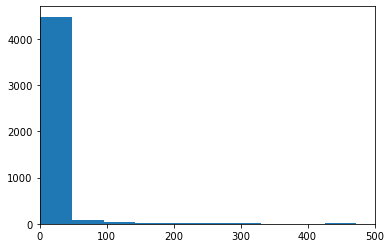

In [379]:
plt.hist(list(occtr_cnt.values()), bins=50)
plt.xlim(0,500)
plt.show()

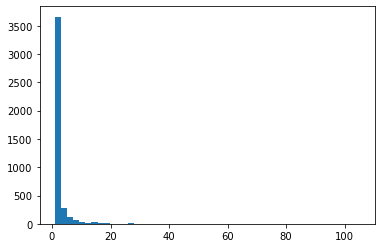

In [380]:
plt.hist(list(occtr_diff.values()), bins=50)
#plt.xlim(0,50)
plt.show()

In [382]:
# similarity between pairs of occupations in 2018
socsim = {}
jlist = set()
for j1 in jyv:
    if 2018 in jyv[j1]:
        for j2 in jyv:
            pair = tuple(sorted([j1.lower(), j2.lower()]))
            if (2018 in jyv[j2]) and (j2 != j1) and (pair not in socsim):
                socsim[pair] = np.dot(jyv[j1][2018], jyv[j2][2018]) / (np.linalg.norm(jyv[j1][2018])* np.linalg.norm(jyv[j2][2018]))
                jlist.add(pair[0])
                jlist.add(pair[1])

In [383]:
# bls employment
df_2018=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')

bls_on18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in yjn[2018] and j != '*'and j !='#':
        bls_on18[i.lower()] = j

In [384]:
# similarity, log flow, log employment multiplication
sim_tr = {}
mismatch = set()
pairs = []
flows = 0
for p in occtr_diff:
    if p in socsim and p[0] in bls_on18 and p[1] in bls_on18:
        sim_tr[p] = (socsim[p], np.log(occtr_diff[p]), np.log(bls_on18[p[0]] * bls_on18[p[1]]))
        flows += occtr_diff[p]
    else:
        pairs.append(p)
    if p[0] not in jlist:
        mismatch.add(p[0])
    if p[1] not in jlist:
        mismatch.add(p[1])
        
len(sim_tr), len(occtr_diff)     

(1956, 4265)

In [385]:
flows

4888

In [386]:
len(pairs), flows, sum(list(occtr_diff.values()))

(2309, 4888, 10685)

In [387]:
mismatch

{'agricultural and food scientists',
 'air traffic controllers and airfield operations specialists',
 'aircraft pilots and flight engineers',
 'announcers',
 'architects, except naval',
 'archivists, curators, and museum technicians',
 'artists and related workers',
 'athletes, coaches, umpires, and related workers',
 'automotive and watercraft service attendants   ',
 'baggage porters, bellhops, and concierges',
 'bailiffs, correctional officers, and jailers',
 'billing and posting clerks ',
 'biological scientists',
 'brickmasons, blockmasons, and stonemasons',
 'broadcast and sound engineering technicians and radio operators',
 'bus drivers',
 'butchers and other meat, poultry, and fish processing workers',
 'carpet, floor, and tile installers and finishers',
 'cement masons, concrete finishers, and terrazzo workers',
 'chemical processing machine setters, operators, and tenders',
 'chemists and materials scientists',
 'claims adjusters, appraisers, examiners, and investigators',
 '

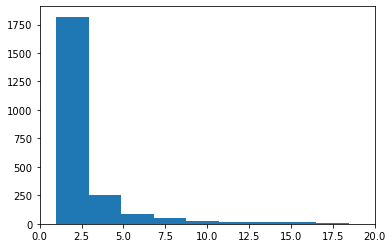

In [388]:
mv = []
for p in pairs:
    mv.append(occtr_cnt[p])

plt.hist(mv, bins=50)
plt.xlim(0,20)
plt.show()

In [389]:
print(sum(mv) / sum(list(occtr_cnt.values())))
print(sum(list(occtr_diff.values())) / sum(list(occtr_cnt.values())))
print(sum(mv) / sum(list(occtr_diff.values())))

0.06868971727847951
0.12660852667251227
0.5425362657931679


In [390]:
import statsmodels.api as sm

x1,y1,x2 = zip(*list(sim_tr.values()))
#add constant to predictor variables

regdf = pd.DataFrame()
regdf['skill similarity for i and j'] = x1
regdf['log(emp_i * emp_j)'] = x2
x = regdf[['log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y1, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     128.5
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           6.78e-29
Time:                        17:09:02   Log-Likelihood:                -2127.2
No. Observations:                1956   AIC:                             4258.
Df Residuals:                    1954   BIC:                             4270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7244      0

In [393]:
x1,y1,x2 = zip(*list(sim_tr.values()))
#add constant to predictor variables

regdf = pd.DataFrame()
regdf['skill similarity for i and j'] = x1
regdf['log(emp_i * emp_j)'] = x2
x = regdf[['skill similarity for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y1, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     161.1
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           1.68e-65
Time:                        17:09:04   Log-Likelihood:                -2040.1
No. Observations:                1956   AIC:                             4086.
Df Residuals:                    1953   BIC:                             4103.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

(0.28330350494588835, 4.793276147661129e-38)


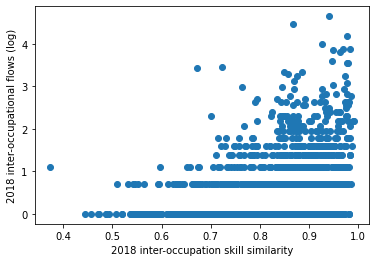

In [296]:
x1,y1 = zip(*list(sim_tr.values()))
corr2=pearsonr(x1, y1)
print(corr2)

plt.scatter(x1, y1)
plt.xlabel('2018 inter-occupation skill similarity')
plt.ylabel('2018 inter-occupational flows (log)')
#plt.xticks(np.arange(6))
plt.show()

## Figure 1a,b

In [87]:
# adjust positions and assign color to each cluster
colors = ['#bae4e3', '#bfdbf3', '#f3d6e8', '#fff0e1', '#a18ab0', '#8891a1']
oripos={0: pos0, 1:pos1, 2:pos2, 3:pos3, 4:pos4, 5:pos5}
movpos={0:(-0.2, -1),1:(-0.7, 1.2),2:(-1.7, 0.2),3:(1.2, -1.3),4:(1, 1),5:(2, 0)}
pos={}
col={}
for c in oripos:
    xm,ym=movpos[c]
    for p in oripos[c]:
        xp, yp=oripos[c][p]
        pos[p] = (xp+xm, yp+ym) 
        col[p] = colors[c]

In [89]:
# get nearest old skill for each new skill
newc = [s for s in jys["Computer Programmers"][2018] if s not in jys["Computer Programmers"][2010]]
dictpairc={}
dictlenc={}
for s in newc:
    if s in pos:
        dictpairc[s] = 0
        xi, xj = pos[s]
        dis=10000
        for s1 in jys["Computer Programmers"][2010]:
            if s1 in pos:
                xa,xb=pos[s1]
                d=(xi-xa)**2 + (xj-xb)**2
                if d < dis:
                    dictpairc[s] = s1
                    dis=d
        dictlenc[s]=dis

newj='Food Batchmakers'
newb = [s for s in jys[newj][2018] if s not in jys[newj][2010]]
dictpairb={}
dictlenb={}
for s in newb:
    if s in pos:
        dictpairb[s] = 0
        xi, xj = pos[s]
        dis=10000
        for s1 in jys[newj][2010]:
            xa,xb=pos[s1]
            d=(xi-xa)**2 + (xj-xb)**2
            if d < dis:
                dictpairb[s] = s1
                dis=d
                
        dictlenb[s]=dis

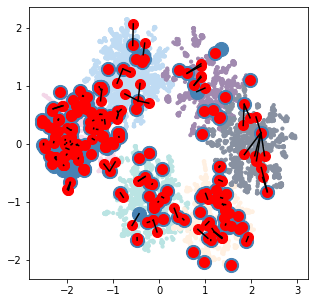

In [40]:
# figure 1a
x,y=np.array(list(pos.values())).T

fig = plt.figure(figsize=(5,5))

# computer programmer
ax1 = fig.add_subplot(111)
# all skills
plt.scatter(x,y,color=list(col.values()), s=10)
#2010
xc10,yc10=np.array(list(pos[i] for i in jys["Computer Programmers"][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
# 2018
xc18,yc18=np.array(list(pos[i] for i in jys["Computer Programmers"][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairc.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)
#     ax1.annotate("",xy=(xj,yj), xycoords='data',xytext=(xi,yi), textcoords='data',
#                 arrowprops=dict(arrowstyle="<-", color="black",shrinkA=5, shrinkB=5,
#                 patchA=None,patchB=None,connectionstyle='angle3,angleA=0,angleB=90',),zorder=1)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P1.pdf')  

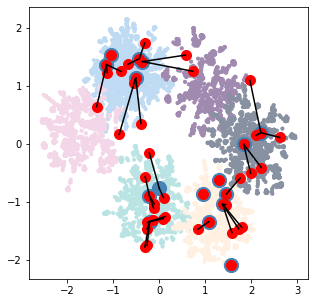

In [124]:
# figure 1b
x,y=np.array(list(pos.values())).T

fig = plt.figure(figsize=(5,5))
# FoodBatchmakers
ax2 = fig.add_subplot(111)
# all skills
plt.scatter(x,y,color=list(col.values()), s=10)
# 2010
xc10,yc10=np.array(list(pos[i] for i in jys[newj][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
#2018
xc18,yc18=np.array(list(pos[i] for i in jys[newj][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairb.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)
#     ax2.annotate("",xy=(xj,yj), xycoords='data',xytext=(xi,yi), textcoords='data',
#                 arrowprops=dict(arrowstyle="<-", color="black",shrinkA=5, shrinkB=5,
#                 patchA=None,patchB=None,connectionstyle='angle3,angleA=0,angleB=90',),zorder=1)
# for i in pos:
#     if i in slist:
#         x,y=pos[i]
#         #r=np.sqrt(x**2+y**2)
#         plt.text(x,y,i, fontsize=14, ha='left')
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P2_FoodBatchmakers.pdf') 

## Figure 1c, d

In [175]:
# with employer job skill data
occ_y_freq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        freq = int(line_lst[2])
        if year == 2010 or year==2018:
            occ_y_freq[job][year] = freq

occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if year in jyn[job]:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    occ_y_skill_freq[job][year][skill] = float(skill_tfidf.split('_')[1])
                    occ_y_sfreq[job][year] += float(skill_tfidf.split('_')[1])

# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if 2010 in occ_y_sfreq[j] and 2018 in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j][2010] / occ_y_sfreq[j][2018]) / (occ_y_freq[j][2010]/occ_y_freq[j][2018])
            if jw1[j] > 1:
                jw1[j] = 1
                    
# skill probability
jysp = copy.deepcopy(occ_y_skill_freq)
for j in jysp:
    if j in occ_y_freq:
        for y in jysp[j]:
            if y in occ_y_freq[j]:
                for s in jysp[j][y].keys():
                    jysp[j][y][s] = jysp[j][y][s]/occ_y_freq[j][y]

In [176]:
# Deming's measurement (sample with non-missing employer): Food Batchmakers and Computer Programers
def skill_change(j, jysp, jw1):
    
    bc={}
    if 2010 in jysp[j] and 2018 in jysp[j]:
        # get the union of skills of 2 years
        alls = set(jysp[j][2010].keys()).union(set(jysp[j][2018].keys()))
        # skill probability change
        for s in alls:
            bc[s] = abs(jysp[j][2018][s] - jysp[j][2010][s]) * jw1[j]
            
    return bc

In [179]:
# Deming and Noray's measure of skill probability change
occsc80_1['Food Batchmakers'], occsc80_1["Computer Programmers"]

(2.708437305486499, 7.452889431122576)

In [180]:
# decompose change to each skill
cc=skill_change("Computer Programmers", jysp, jw1)
bc=skill_change('Food Batchmakers', jysp, jw1)
len(bc), len(cc)

(915, 6875)

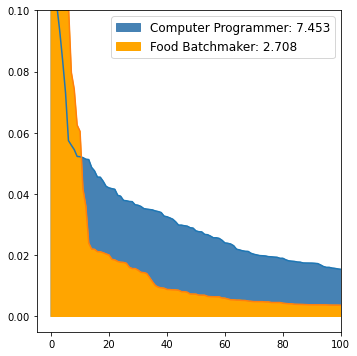

In [277]:
# Figure 1c
fig = plt.figure(figsize=(5,5))

# computer programmer
ax1 = fig.add_subplot(111)
sc=sorted(cc.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 7.453")
sb = sorted(bc.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 2.708")
plt.legend(fontsize=12)
#plt.ylabel("Change in probability", fontsize=18)
#plt.xlabel("Decreasing rank of skills", fontsize=18)
plt.tight_layout()
plt.xlim(-5,100)
plt.ylim(-0.005,0.1)

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig1skillprob.pdf')

In [188]:
# change induced by Food Batchmakers new skills: 
scB = {}
newj='Food Batchmakers'
for ns in jys[newj][2018]:
    if ns not in jys[newj][2010]:
        # a new job vector without having the focal new skill
        newv = np.mean([model.wv[s] for s in jys[newj][2018] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal new skill
        newc = 1- np.dot(newv, jyv[newj][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv[newj][2010]))
        scB[ns] = abs(jtr[newj] - newc)

In [189]:
# Change induced by Food Batchmakers old(dropped) skills:
soB = {}
newj='Food Batchmakers'
for ns in jys[newj][2010]:
    if ns not in jys[newj][2018]:
        # a new old vector without having the focal old(dropped) skill
        oldv = np.mean([model.wv[s] for s in jys[newj][2010] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal old skill
        newc = 1- np.dot(oldv, jyv[newj][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv[newj][2018]))
        soB[ns] = abs(jtr[newj] - newc)

In [190]:
# change induced by Computer programmer new skills: 
scC = {}
for ns in jys["Computer Programmers"][2018]:
    if ns not in jys["Computer Programmers"][2010]:
        newv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2018] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(newv, jyv["Computer Programmers"][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv["Computer Programmers"][2010]))
        scC[ns] = abs(jtr["Computer Programmers"] - newc)

In [191]:
# change induced by Computer programmer old(dropped) skills: 
soC = {}
for ns in jys["Computer Programmers"][2010]:
    if ns not in jys["Computer Programmers"][2018]:
        oldv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2010] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(oldv, jyv["Computer Programmers"][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv["Computer Programmers"][2018]))
        soC[ns] = abs(jtr["Computer Programmers"] - newc)

In [192]:
sum(scB.values()), sum(scC.values()), sum(soB.values()), sum(soC.values())

(0.050115108489990234,
 0.02186340093612671,
 0.016377389430999756,
 0.005195677280426025)

In [264]:
sum(scB.values())+sum(soB.values()),sum(scC.values())+ sum(soC.values()) 

(0.06649249792098999, 0.027059078216552734)

In [193]:
jtr['Food Batchmakers'], jtr["Computer Programmers"]

(0.08175450563430786, 0.01701796054840088)

In [262]:
# combine old and new skills
saB = {**scB, **soB}
saC = {**scC, **soC}

In [271]:
len(saB), len(saC), len(soB), len(scB), len(soC), len(scC)

(35, 158, 2, 33, 49, 109)

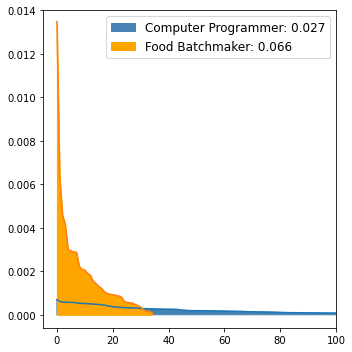

In [276]:
# computer programmer
fig = plt.figure(figsize=(5,5))
#ax1 = fig.add_subplot(111)

sc=sorted(saC.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 0.027")
sb = sorted(saB.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 0.066")
plt.legend(fontsize=12)
#plt.ylabel("Change in embedding distance", fontsize=18)
#plt.xlabel("Decreasing rank of skills", fontsize=18)
plt.xlim(-5, 100)
plt.ylim(-0.0006, 0.014)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig1skillembcombine.pdf')

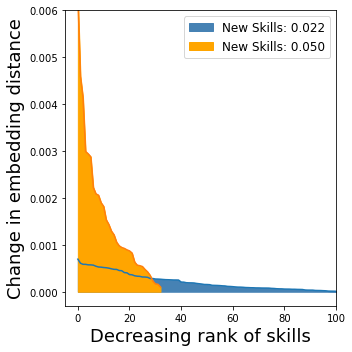

In [208]:
# computer programmer
fig = plt.figure(figsize=(5,5))
#ax1 = fig.add_subplot(111)

sc=sorted(scC.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="New Skills: 0.022")
sb = sorted(scB.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="New Skills: 0.050")
plt.legend(fontsize=12)
plt.ylabel("Change in embedding distance", fontsize=18)
plt.xlabel("Decreasing rank of skills", fontsize=18)
plt.xlim(-5, 100)
plt.ylim(-0.0003, 0.006)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig1skillembnew.pdf')

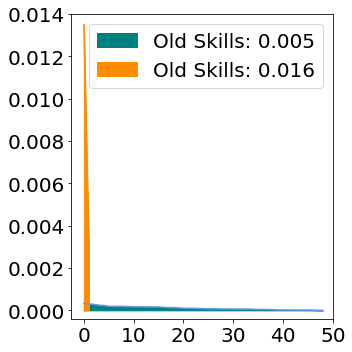

In [209]:
# computer programmer
fig = plt.figure(figsize=(5,5))
#ax1 = fig.add_subplot(111)

sc=sorted(soC.values(), reverse=True)
plt.plot(sc,color="cornflowerblue")
plt.fill_between(range(len(sc)),sc,0,color="teal", label="Old Skills: 0.005")
sb = sorted(soB.values(), reverse=True)
plt.plot(sb,color="darkorange")
plt.fill_between(range(len(sb)),sb,0,color="darkorange", label="Old Skills: 0.016")
plt.legend(fontsize=20)
plt.xlim(-2.5, 50)
plt.ylim(-0.0004, 0.014)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig1skillembold.pdf')

### Figure 2

In [10]:
# calculate CI using bootstrap
def calculateCI2(data,method,n, k):
    m=int(len(data)*k) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    
    return (b-a)/2

In [ ]:
# job vector change measurement
dfsni_jv = pd.DataFrame(columns=['skill#', "skillchange"])
for o in osn:
    if o in jtr: #o in occsc80_1 and 
        dfsni_jv = dfsni_jv.append({'skill#': osn[o], "skillchange": jtr[o]}, ignore_index=True)
        
dfsni_jv['skill#_bins'] = pd.cut(x=dfsni_jv['skill#'], bins=list(range(0, 90, 10)))
snkeys_jv = [str(k) for k in list(dfsni_jv.groupby(['skill#_bins']).groups.keys())]
xsn_pos = np.arange(len(snkeys_jv))
snmeans_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].mean())
snstd_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].apply(calculateCI2, method="mean", n=50,k=0.8))

In [ ]:
# edu and job change
ei = defaultdict(lambda:[])
for o in oe:
    if o in jtr:
        if oe[o] < 13:
            ei["high school"].append(jtr[o])
        elif 13 <= oe[o] < 15:
            ei["Associate"].append(jtr[o])
        elif 15 <= oe[o] < 16.5:
            ei["Bachelor"].append(jtr[o])
        else:
            ei["Master/Doctoral"].append(jtr[o])

ekeys = ['high school', 'Associate', 'Bachelor', 'Master/Doctoral']
emeans = [np.mean(ei[key]) for key in ekeys]
estd = [calculateCI2(ei[key],'mean',50, 0.8) for key in ekeys]
xe_pos = np.arange(len(ekeys))

        
# pay and job change
pi = defaultdict(lambda:[])
for o in op:
    if o in jtr:
        if op[o] <= 40000:
            pi["<= 40K"].append(jtr[o])
        elif 40000 <= op[o] < 80000:
            pi["40k-80k"].append(jtr[o])
        else:
            pi[">80k"].append(jtr[o])

pkeys = ['<= 40K', '40k-80k', '>80k']
pmeans = [np.mean(pi[key]) for key in pkeys]
pstd = [calculateCI2(pi[key],'mean',50, 0.8) for key in pkeys]
#pstd = calculateCI2(pi,'mean',50, pkeys, 0.8)
xp_pos = np.arange(len(pkeys))

In [219]:
# education distance and skill distance
svd, edud = zip(*osvdedud)
z_scores = np.array(svd)
z_scores = (z_scores - z_scores.mean()) / z_scores.std()
ze = list(zip(z_scores, edud))
sci = defaultdict(lambda:[])
for s,e in ze:
    if s < -1:
        sci["<-1SD"].append(e)
    elif -1 <= s <= 1:
        sci["-1SD - +1SD"].append(e)
    else:
        sci[">+1SD"].append(e)

sckeys = ["<-1SD", "-1SD - +1SD", ">+1SD"]
scmeans = [np.mean(sci[key]) for key in sckeys]
scstd = [calculateCI2(sci[key],'mean',50, 0.8) for key in sckeys]
xsc_pos = np.arange(len(sckeys))

In [88]:
# correlation between education and job skill change
esc = {}
esc_cat = {}
for o in oe:
    if o in jtr:
        esc[o] = (oe[o], jtr[o])
        esc_cat[o] = (round(oe[o]), jtr[o])
        
x1,y1 = zip(*list(esc.values()))
corr2=pearsonr(x1, y1)
x1c,y1c = zip(*list(esc_cat.values()))
corrsp = spearmanr(x1c, y1c)
print(corr2)
print(corrsp)

(-0.18460347422757495, 5.999664437871287e-07)
SpearmanrResult(correlation=-0.2985531825261429, pvalue=2.608196227340753e-16)


In [18]:
# correlation between education and job skill change
esc = {}
esc_cat = {}
for o in oe:
    if o in jtr:
        esc[o] = (oe[o], jtr[o])
        esc_cat[o] = (round(oe[o]), jtr[o])
        
x1,y1 = zip(*list(esc.values()))
corr2=pearsonr(x1, y1)
x1c,y1c = zip(*list(esc_cat.values()))
corrsp = spearmanr(x1c, y1c)
print(corr2)
print(corrsp)

(-0.18460347422757495, 5.999664437871287e-07)
SpearmanrResult(correlation=-0.2985531825261429, pvalue=2.608196227340753e-16)


In [20]:
# correlation between pay and job skill change
psc = {}
for o in op:
    if o in jtr:
        psc[o] = (op[o], jtr[o])

x1,y1 = zip(*list(psc.values()))
corr2=pearsonr(x1, y1)
print(corr2)

(-0.12269245756169325, 0.0009626072613207438)


In [22]:
# correlation between skill number and job skill change
snsc = {}
for o in osn:
    if o in jtr:
        snsc[o] = (np.log(osn[o]), jtr[o])
        
x1,y1 = zip(*list(snsc.values()))
corr2=pearsonr(x1, y1)
print(corr2)

(-0.6644466553623556, 8.857483645309603e-94)


In [226]:
# correlation between skill distance and education difference
x, y = zip(*osvdedud)
spearmanr(x, y), pearsonr(x, y)

(SpearmanrResult(correlation=0.13521232405663985, pvalue=1.5003825443311582e-06),
 (0.14572700957545776, 2.111788271143556e-07))

In [120]:
# occupation group median stability
gsta = {}
for g in go:
    #gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr and jtr[j] >= gol[g]])
    gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr])

gsta = dict(sorted(gsta.items(), key=operator.itemgetter(1), reverse=True))

df = pd.DataFrame(columns = ["occupation","group", "stability"])
occ=[]
gr=[]
sta=[]
for g in gsta:
    for j in go[g]:
        if j in jtr:
            occ.append(j)
            gr.append(g[:-12])
            sta.append(jtr[j])
        
df["occupation"] = occ
df["group"] = gr
df["stability"] = sta

data=defaultdict(lambda:[])
for i,j in zip(df['group'], df['stability']):
    data[i].append(j) 

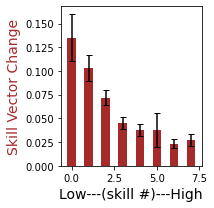

In [136]:
# skill number and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax1 = fig.add_subplot(111)
f3_ax1.bar(xsn_pos, snmeans_jv, width = 0.5, yerr=snstd_jv, color = "brown", align='center', 
           alpha=1, ecolor='black', capsize=3, zorder=10)
f3_ax1.set_ylabel('Skill Vector Change', color = "brown", fontsize=14) 
#f3_ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
f3_ax1.yaxis.set_tick_params(labelsize=10)
f3_ax1.set_xlabel('Low---(skill #)---High', fontsize=14)
#f3_ax1.set_ylim(0, 0.2)
plt.tight_layout()

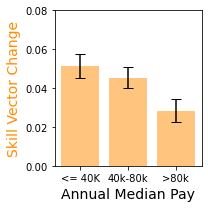

In [133]:
# pay and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax3 = fig.add_subplot(111)
f3_ax3.bar(xp_pos, pmeans, yerr=pstd, color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax3.set_ylabel('Skill Vector Change', color = 'darkorange', fontsize=14)
f3_ax3.set_xlabel('Annual Median Pay', fontsize=14)
f3_ax3.set_xticks(xp_pos)
f3_ax3.set_xticklabels(pkeys,size=10)
#plt.xticks(rotation=30)
f3_ax3.yaxis.set_tick_params(labelsize=10)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P2.pdf')

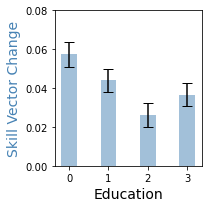

In [43]:
# education and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xe_pos, emeans, yerr=estd, width = 0.4, color = 'steelblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'steelblue', fontsize=14)
f3_ax2.set_xlabel('Education', fontsize=14)
f3_ax2.set_xticks(xe_pos)
#f3_ax2.set_xticklabels(ekeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
#plt.xticks(rotation=30)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P3.pdf')

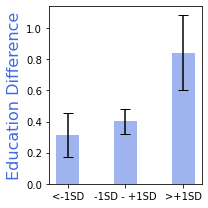

In [232]:
fig = plt.figure(figsize=(3, 3),facecolor='white')
f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xsc_pos, scmeans, yerr=scstd, width=0.4, color = 'royalblue', align='center', alpha=0.5, ecolor='black', capsize=5)
#f3_ax2.set_xlabel('Skill Vector Distance', color = 'royalblue', fontsize=14)
f3_ax2.set_ylabel('Education Difference', color = 'royalblue', fontsize=16)
#f3_ax2.set_xlabel('Education Change', fontsize=14)
f3_ax2.set_xticks(xsc_pos)
f3_ax2.set_xticklabels(sckeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
#plt.yticks([0.00, 0.02, 0.04, 0.06, 0.08])
#plt.xticks(rotation=30)
#plt.ylim(0,0.08)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig2edudifskilldis.pdf')

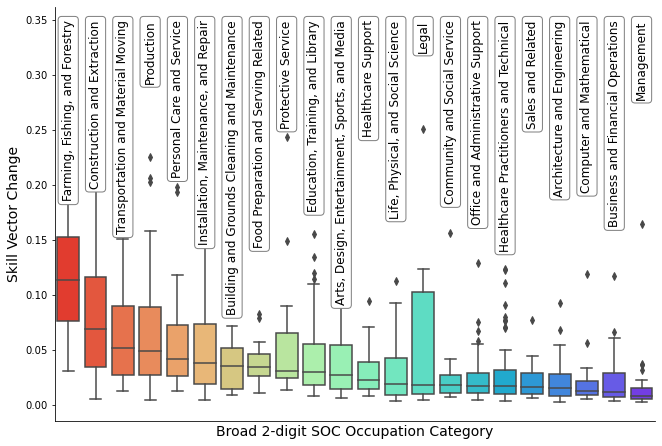

In [147]:
fig = plt.figure(figsize=(9, 6),facecolor='white')

f3_ax4 = fig.add_subplot(111)

f3_ax4= sns.boxplot(y="stability", x="group", data=df, palette="rainbow_r")
#f3_ax4.set_ylim(0,0.2)
#ax.set_title("Job Stability Index",fontsize=22)
f3_ax4.set_ylabel("Skill Vector Change",fontsize=14)
f3_ax4.set_xlabel("Broad 2-digit SOC Occupation Category",fontsize=14)
f3_ax4.set_xticks([])
f3_ax4.yaxis.set_tick_params(labelsize=10)
names= list(data.keys())
for i in range(len(data.keys())):
    #name = " ".join(names[i].split()[:3]) + "\n" + " ".join(names[i].split()[3:])
    name=names[i]
    f3_ax4.text(i, 0.35, name, rotation=90, ha='center', va="top", fontsize=12,
           bbox=dict(boxstyle="round",
                   ec="grey",#(1., 0.5, 0.5),
                   fc='white',
                   ))
sns.despine()
plt.subplots_adjust(hspace=0.0)
plt.tight_layout(pad=0)

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P4.pdf')

In [ ]:
if try to combine panels
fig3 = plt.figure(figsize=(9,9), constrained_layout=True)

# skill number and job change
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, 0])
# paste fig a


f3_ax2 = fig3.add_subplot(gs[0, 2])
# paste fig b

f3_ax3 = fig3.add_subplot(gs[0, 1])
# paste fig c

f3_ax4 = fig3.add_subplot(gs[1:, :])
# paste fig d

### Figure 3

### Company

In [18]:
jylsd = defaultdict(lambda:defaultdict(lambda:0))
yjlsd = defaultdict(lambda:defaultdict(lambda:0))
lcjtr = {}
scjtr= {}
for j in lcjyv:
    if j in scjyv and j in jyn:
        if 2010 in lcjyv[j] and 2018 in lcjyv[j] and 2010 in scjyv[j] and 2018 in scjyv[j] and jyn[j][2010] > 100 and jyn[j][2018] > 100:
            jylsd[j][2010] = 1- np.dot(lcjyv[j][2010], scjyv[j][2010])/(np.linalg.norm(lcjyv[j][2010])* np.linalg.norm(scjyv[j][2010]))
            jylsd[j][2018] = 1- np.dot(lcjyv[j][2018], scjyv[j][2018])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(scjyv[j][2018]))
            yjlsd[2010][j] = jylsd[j][2010]
            yjlsd[2018][j] = jylsd[j][2018]
            lcjtr[j] = 1 - np.dot(lcjyv[j][2018], lcjyv[j][2010])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(lcjyv[j][2010]))
            scjtr[j] = 1 - np.dot(scjyv[j][2018], scjyv[j][2010])/(np.linalg.norm(scjyv[j][2018])* np.linalg.norm(scjyv[j][2010]))

In [19]:
len(jylsd), len(lcjtr), len(scjtr)

(556, 556, 556)

In [21]:
# average skill change of large and small company from 2010 to 2018
np.mean(list(lcjtr.values())), np.mean(list(scjtr.values()))

(0.04373546137655382, 0.07546289179393713)

In [23]:
# t test for the difference between average skill change of large and small company from 2010 to 2018
stats.ttest_rel(list(lcjtr.values()), list(scjtr.values()))

Ttest_relResult(statistic=-12.504636702472864, pvalue=8.73625478162196e-32)

In [20]:
# mean of large and small company distance in 2010 and 2018
np.mean(list(yjlsd[2010].values())), np.mean(list(yjlsd[2018].values()))

(0.08712869148245818, 0.052927221432864234)

In [22]:
# t test for the difference between mean of large and small company distance in 2010 and 2018
stats.ttest_rel(list(yjlsd[2010].values()), list(yjlsd[2018].values()))

Ttest_relResult(statistic=12.113759548261173, pvalue=3.920678520822205e-30)

In [254]:
# prepare data to plot large and small company average change from 2010 to 2018
cmeans = [np.mean(list(lcjtr.values())), np.mean(list(scjtr.values()))]
cstd = [calculateCI2(list(lcjtr.values()),'mean',50, 0.8), calculateCI2(list(scjtr.values()),'mean',50, 0.8)]
xc_pos = np.arange(len(cmeans))
ckeys = ['large', 'small']

# prepare data to plot the large and small company difference in 2010 and 2018
ymeans = [np.mean(list(yjlsd[2010].values())), np.mean(list(yjlsd[2018].values()))]
ystd = [calculateCI2(list(yjlsd[2010].values()),'mean',50, 0.8), calculateCI2(list(yjlsd[2018].values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']

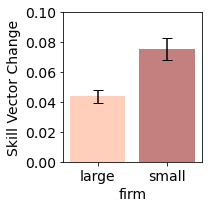

In [255]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f1 = fig.add_subplot(111)
f1.bar(xc_pos[0], cmeans[0], yerr=cstd[0], color = 'lightsalmon', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xc_pos[1], cmeans[1], yerr=cstd[1], color = 'darkred', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('Skill Vector Change', fontsize=14)
f1.set_xlabel('firm', fontsize=14)
f1.set_xticks(xc_pos)
f1.set_xticklabels(ckeys,size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("2010 vs. 2018")
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3firmchange.pdf')

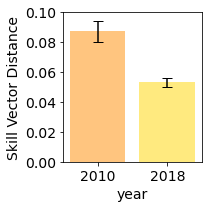

In [237]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f2 = fig.add_subplot(111)
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.set_ylabel('Skill Vector Distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels(ykeys,size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("large vs. small firm")

plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3firmdiff.pdf')

### Market

In [41]:
jylslocd = defaultdict(lambda:defaultdict(lambda:0))
yjlslocd = defaultdict(lambda:defaultdict(lambda:0))
llocjtr = {}
slocjtr= {}
for j in llocjyv:
    if j in slocjyv and j in jyn:
        if 2010 in llocjyv[j] and 2018 in llocjyv[j] and 2010 in slocjyv[j] and 2018 in slocjyv[j] and jyn[j][2010] > 100 and jyn[j][2018] > 100:
            jylslocd[j][2010] = 1- np.dot(llocjyv[j][2010], slocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2010])* np.linalg.norm(slocjyv[j][2010]))
            jylslocd[j][2018] = 1- np.dot(llocjyv[j][2018], slocjyv[j][2018])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(slocjyv[j][2018]))
            yjlslocd[2010][j] = jylslocd[j][2010]
            yjlslocd[2018][j] = jylslocd[j][2018]
            llocjtr[j] = 1 - np.dot(llocjyv[j][2018], llocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(llocjyv[j][2010]))
            slocjtr[j] = 1 - np.dot(slocjyv[j][2018], slocjyv[j][2010])/(np.linalg.norm(slocjyv[j][2018])* np.linalg.norm(slocjyv[j][2010]))

In [42]:
len(jylslocd), len(llocjtr), len(slocjtr)

(625, 625, 625)

In [43]:
# average skill change of large and small market from 2010 to 2018
np.mean(list(llocjtr.values())), np.mean(list(slocjtr.values()))

(0.04947633752822876, 0.07788015079498291)

In [44]:
# t test for the difference between average skill change of large and small market from 2010 to 2018
stats.ttest_rel(list(llocjtr.values()), list(slocjtr.values()))

Ttest_relResult(statistic=-11.901989607306222, pvalue=1.400902066484937e-29)

In [45]:
# mean of large and small market distance in 2010 and 2018
np.mean(list(yjlslocd[2010].values())), np.mean(list(yjlslocd[2018].values()))

(0.05525299425125122, 0.03757993698120117)

In [46]:
# t test for the difference between mean of large and small market distance in 2010 and 2018
stats.ttest_rel(list(yjlslocd[2010].values()), list(yjlslocd[2018].values()))

Ttest_relResult(statistic=7.803104136749592, pvalue=2.5531700505919495e-14)

In [252]:
# prepare data to plot large and small market average change from 2010 to 2018
cmeans = [np.mean(list(llocjtr.values())), np.mean(list(slocjtr.values()))]
cstd = [calculateCI2(list(llocjtr.values()),'mean',50, 0.8), calculateCI2(list(slocjtr.values()),'mean',50, 0.8)]
xc_pos = np.arange(len(cmeans))
ckeys = ['large', 'small']

# prepare data to plot the large and small market difference in 2010 and 2018
ymeans = [np.mean(list(yjlslocd[2010].values())), np.mean(list(yjlslocd[2018].values()))]
ystd = [calculateCI2(list(yjlslocd[2010].values()),'mean',50, 0.8), calculateCI2(list(yjlslocd[2018].values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']

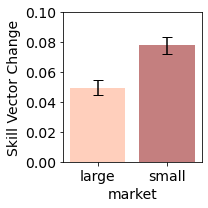

In [253]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f1 = fig.add_subplot(111)
f1.bar(xc_pos[0], cmeans[0], yerr=cstd[0], color = 'lightsalmon', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xc_pos[1], cmeans[1], yerr=cstd[1], color = 'darkred', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('Skill Vector Change', fontsize=14)
f1.set_xlabel('market', fontsize=14)
f1.set_xticks(xc_pos)
f1.set_xticklabels(ckeys,size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("2010 vs. 2018")
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3marketchange.pdf')

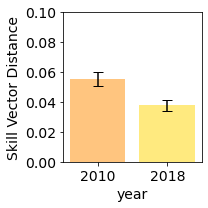

In [240]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f2 = fig.add_subplot(111)
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.set_ylabel('Skill Vector Distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels(ykeys,size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("large vs. small market")

plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3marketdiff.pdf')

### US map

In [53]:
# location - job - post number
Year2018=defaultdict(lambda:defaultdict(lambda:0))
locsize18=defaultdict(lambda:0)
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/year_jobid_cz_occ.txt','r') as f:
    for line in f:
        linelst=line[:-1].split('\t')
        year=int(linelst[0])
        if year ==2018: 
            occ=linelst[2]
            cz=float(linelst[3])
            if occ !='na':
                Year2018[cz][occ] += 1
                locsize18[cz]+=1
len(Year2018), len(locsize18), np.percentile(list(locsize18.values()), [90])[0]

(658, 658, 83364.70000000007)

In [54]:
# skill change score for each cz
Cscore={}
n=0
SizePerc90=round(np.percentile(list(locsize18.values()), [90])[0])
for town in Year2018:
    n+=1
    if n%100==0:
        flushPrint(n/100)
    if town in locsize18:
        # get rid of outliers
        if 100 < locsize18[town]: #100 < < 10000:
            # use different dictionary for different location
            if locsize18[town]>SizePerc90:
                dic=llocjtr
            else:
                dic=slocjtr
            # more than three jobs per town
            if len(Year2018[town])>=3:
                jp=defaultdict(lambda:0)
                for j in Year2018[town]:
                    if j in dic:
                        jp[j]+=Year2018[town][j]
                s=sum([v for v in jp.values()])
                jp=dict((k,v/s) for k,v in jp.items())
                c_score=sum([dic[i]*jp[i] for i in jp])
                Cscore[town]=c_score

6

In [58]:
czcha = {'LM_Code': list(Cscore.keys()), 'change': list(Cscore.values())}
czcha_df=pd.DataFrame(data=czcha)
czcha_df.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/CZChange.csv')
len(Cscore)

652

In [143]:
# us commuting zone data
czs = geopandas.read_file(
    '/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/ERS10.geojson')
print(len(czs))
# append change to this dataframe
czs = czs.merge(czcha_df, how='inner', on='LM_Code')
czs = czs[['LM_Code', 'change', 'geometry']]
print(len(czs))

658
652


In [243]:
# us commuting zone data
czs = geopandas.read_file(
    '/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/ERS10.geojson')
print(len(czs))
# append change to this dataframe
czs = czs.merge(czcha_df, how='inner', on='LM_Code')
czs = czs[['LM_Code', 'change', 'geometry']]
print(len(czs))

658
652


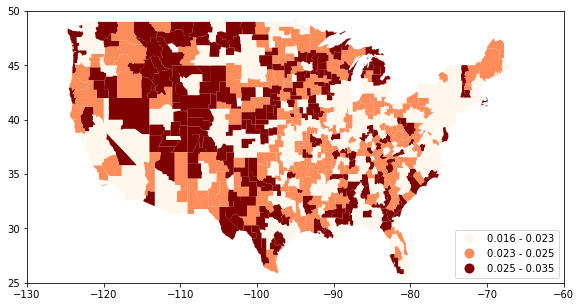

In [144]:
# cz - average job skill change in three quantiles
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

czs.plot(column='change',
           ax=ax,
           legend=True,
            cmap='OrRd',
            figsize=(20, 20),
            scheme='quantiles',
            k=3,
            legend_kwds={'loc': 'lower right'}
            )
plt.xlim(-130,-60)
plt.ylim(25, 50)

# get all upper bounds
upper_bounds = mapclassify.Quantiles(czs.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = czs.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3cz.pdf')

In [244]:
# us state geometry data
states = geopandas.read_file(
    '/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/usmap/usa-states-census-2014.shp')

statematch = []
statechas = defaultdict(lambda:[])
for cz, ind, cha in zip(czs['geometry'], czs['LM_Code'], czs['change']):
    nv = float('nan')
    czst = {}
    for st, name in zip(states['geometry'], states['NAME']):
        czst[name] = cz.intersection(st).area
        if czst[name]>0:
            statechas[name].append(cha)
    czst = sorted(czst.items(), key=operator.itemgetter(1), reverse=True)
    if czst[0][1]>0:
        nv=czst[0][0]
    statematch.append(nv)
        
czs['NAME'] = statematch
print(len(set(czs['NAME'].dropna())), len(czs[czs['NAME'].isna()]), len(statechas))

48 15 49


In [245]:
# state - average job skill change in three quantiles (cz go with largest intersection)
czs=czs.dropna(subset=['NAME'])
czs = czs.groupby('NAME').mean().reset_index()
states_wcha = states.merge(czs, how='inner', on='NAME')
states_wcha = states_wcha.drop_duplicates(['NAME'])

len(states_wcha), len(states)

(48, 58)

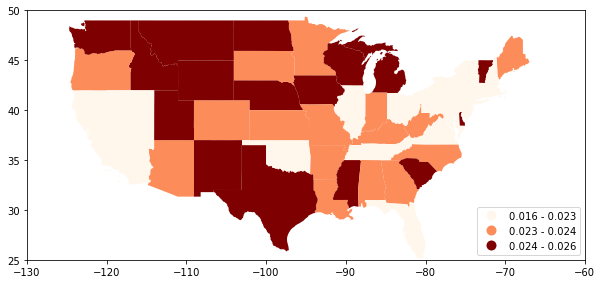

In [247]:
# state - average job skill change in three quantiles (cz go with largest intersection)
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

states_wcha.plot(column='change',
           ax=ax,
           legend=True,
            cmap='OrRd',
            figsize=(20, 20),
            scheme='quantiles',
            k=3,
            legend_kwds={'loc': 'lower right'}
            )

plt.xlim(-130,-60)
plt.ylim(25, 50)

# get all upper bounds
upper_bounds = mapclassify.Quantiles(states_wcha.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = states_wcha.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3state_czlar.pdf')

In [248]:
# state - average job skill change in three quantiles (cz go with all intersections)
meanchas = []
for st in states['NAME']:
    if st in statechas:
        meanchas.append(np.mean(statechas[st]))
    else:
        meanchas.append(float('nan'))
states['change'] = meanchas
states = states.dropna(subset=['change'])
states = states.drop_duplicates(['NAME'])

len(states)

49

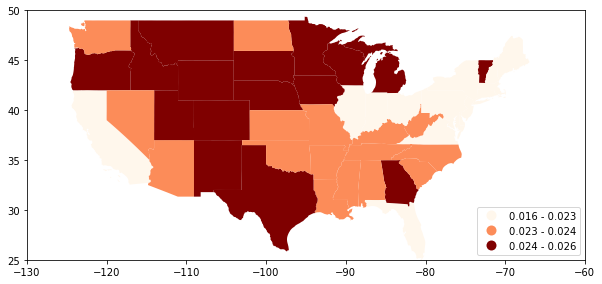

In [251]:
# state - average job skill change in three quantiles (cz go with largest intersections)
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

states.plot(column='change',
           ax=ax,
           legend=True,
            cmap='OrRd',
            figsize=(20, 20),
            scheme='quantiles',
            k=3,
            legend_kwds={'loc': 'lower right'}
            )

plt.xlim(-130,-60)
plt.ylim(25, 50)

# get all upper bounds
upper_bounds = mapclassify.Quantiles(states.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = states.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/mainfig/Fig3state_czall.pdf')

In [170]:
# read in social group data
GenderRace=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/2018_race_gender.xlsx').dropna().reset_index()


# gender by race probability for the entire workforce
bl={}
bl["white women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['White']/10000
bl["white men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['White']/10000
bl["black women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Black or\nAfrican\nAmerican']/10000
bl["black men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Black or\nAfrican\nAmerican']/10000
bl["asian women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Asian']/10000
bl["asian men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Asian']/10000
bl["latinx women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Hispanic\nor Latino']/10000
bl["latinx men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Hispanic\nor Latino']/10000


# all job names to loweer case for matching
osn2= dict([(j.lower(), osn[j]) for j in osn])
jtr2=dict([(j.lower(), jtr[j]) for j in jtr])
js = [o for o in osn2 if o in jtr2]
op2= dict([(j.lower(), op[j]) for j in op])
oe2= dict([(j.lower(), oe[j]) for j in oe])
GenderRace['occupation'] = [occ.lower() for occ in GenderRace['occupation'] ]
GenderRace = GenderRace[GenderRace['occupation'].isin(js)]
# Remove NAs
GenderRace = GenderRace[(GenderRace['Women']!='–') & (GenderRace['White']!='–') & (
                            GenderRace['Hispanic\nor Latino']!='–')]


# actual gender by race probability for each occupation
occgp=defaultdict(lambda:defaultdict(lambda:0))
for a,b,c,d,e,f in zip(GenderRace['occupation'], GenderRace['Women'],GenderRace['White'],
                    GenderRace['Black or\nAfrican\nAmerican'], GenderRace['Asian'], GenderRace['Hispanic\nor Latino']):
    occgp['white women'][a]=b*c/10000
    occgp['white men'][a]=(100-b)*c/10000
    occgp['black women'][a]=b*d/10000
    occgp['black men'][a]=(100-b)*d/10000
    occgp['asian women'][a]=b*e/10000
    occgp['asian men'][a]=(100-b)*e/10000
    occgp['latinx women'][a]=b*f/10000
    occgp['latinx men'][a]=(100-b)*f/10000
    
# classify occupations to each race-gender group
occpar=defaultdict(lambda:[])
occgp=defaultdict(lambda:defaultdict(lambda:0))
k=1.5
for a,b,c,d,e,f in zip(GenderRace['occupation'], GenderRace['Women'],GenderRace['White'],
                    GenderRace['Black or\nAfrican\nAmerican'], GenderRace['Asian'], GenderRace['Hispanic\nor Latino']):
    if b*c/10000 > k*bl['white women']:
        occpar['white women'].append(a)
        occgp[a]['white women']=b*c/10000
    if (100-b)*c/10000 > k*bl['white men']:
        occpar['white men'].append(a)
        occgp[a]['white men']=(100-b)*c/10000
    if b*d/10000 > k*bl['black women']:
        occpar['black women'].append(a)
        occgp[a]['black women']=b*d/10000
    if (100-b)*d/10000 > k*bl['black men']:
        occpar['black men'].append(a)
        occgp[a]['black men']=(100-b)*d/10000
    if b*e/10000 > k*bl['asian women']:
        occpar['asian women'].append(a)
        occgp[a]['asian women']=b*e/10000
    if (100-b)*e/10000 > k*bl['asian men']:
        occpar['asian men'].append(a)
        occgp[a]['asian men']=(100-b)*e/10000
    if b*f/10000 > k*bl['latinx women']:
        occpar['latinx women'].append(a)
        occgp[a]['latinx women']=b*f/10000
    if (100-b)*f/10000 > k*bl['latinx men']:
        occpar['latinx men'].append(a)
        occgp[a]['latinx men']=(100-b)*f/10000
        
        
# add skill change and skill number
GenderRace=GenderRace[['occupation', 'Women', 'White', 'Hispanic\nor Latino']]
GenderRace['skill#'] = [osn2[j] for j in GenderRace['occupation']]
GenderRace['skillchange'] = [jtr2[j] for j in GenderRace['occupation']]

len(GenderRace)

226

In [171]:
# classify occupations into binary groups
def classify(row, var, thresh):
    if var == 'White':
        if row[var] <= thresh:
            return 1
        else:
            return 0 
    else:
        if row[var] > thresh:
            return 1
        else:
            return 0
    
GenderRace['female']=GenderRace.apply (lambda row: classify(row, 'Women', 50), axis=1)
meanwhite=np.mean(GenderRace['White'])
GenderRace['nonwhite']=GenderRace.apply (lambda row: classify(row, 'White', meanwhite), axis=1)
meanhis=np.mean(GenderRace['Hispanic\nor Latino'])
GenderRace['hispanic']=GenderRace.apply (lambda row: classify(row, 'Hispanic\nor Latino', meanhis), axis=1)

In [172]:
# GET THE percentile group of a number in a list
def perc_group(x,n, skills):
    return np.ceil(stats.percentileofscore(skills, x)/n)

# skill number bins
GenderRace['skill#_bins'] = pd.cut(x=GenderRace['skill#'], bins=list(range(0, 550, 50)))
# same volume data bins
GenderRace['skill#perc_bins']=GenderRace['skill#'].apply(perc_group, n=10, skills=list(GenderRace['skill#']))

In [173]:
# skill number and small-large company job vector change 
lscomp = pd.DataFrame(columns=['skill#'])
for o in osn:
    if o in lcjtr and o in scjtr:
        lscomp = lscomp.append({'skill#': osn[o], "Lskillchange": lcjtr[o], 
                                      "Sskillchange": scjtr[o]}, ignore_index=True)
        
lscomp['skill#_bins'] = pd.cut(x=lscomp['skill#'], bins=list(range(0, 550, 50)))
lscomp['skill#perc_bins']=lscomp['skill#'].apply(perc_group,n=10, skills=list(lscomp['skill#']))

# skill number and small-large location job vector change 
lsloc = pd.DataFrame(columns=['skill#'])
for o in osn:
    if o in llocjtr and o in slocjtr:
        lsloc = lsloc.append({'skill#': osn[o], "Lskillchange": llocjtr[o], 
                                      "Sskillchange": slocjtr[o]}, ignore_index=True)
        
lsloc['skill#_bins'] = pd.cut(x=lsloc['skill#'], bins=list(range(0, 550, 50)))
lsloc['skill#perc_bins']=lsloc['skill#'].apply(perc_group, n=10, skills=list(lsloc['skill#']))

In [174]:
# skill number and XXX job vector change difference
def plot(GenderRaceAge, var, gs, x, y, label, color, binname, ylimhi):
    
    if var not in ['large company', 'large market size', 'large market size among large company',
                  'large market size among small company']:
        adf = GenderRaceAge[GenderRaceAge[var]==1]
        bdf = GenderRaceAge[GenderRaceAge[var]==0]
        means = np.array(adf.groupby([binname])['skillchange'].mean()) - np.array(
            bdf.groupby([binname])['skillchange'].mean())
        
    else:
        means = np.array(GenderRaceAge.groupby([binname])['Sskillchange'].mean()) - np.array(
            GenderRaceAge.groupby([binname])['Lskillchange'].mean())

    dele=[]
    for i in range(len(means)):
        if np.isnan(means[i]):
            dele.append(i)

    keys = [str(k) for k in list(GenderRaceAge.groupby([binname]).groups.keys())]
    for i in sorted(dele, reverse=True):
        del keys[i]

    means = means[~np.isnan(means)]

    #snstd_jv = list(df_sndiff.groupby(['skill#_bins'])['skillchangediff'].apply(calculateCI2, method="mean", n=50,k=0.8))

    pos = np.arange(len(keys))
    if gs == 'none':
        f3_ax1 = fig3.add_subplot(111)
    else:
        f3_ax1 = fig3.add_subplot(gs[x, y])
    f3_ax1.bar(pos, means, width = 0.5, color = color, align='center', 
               alpha=1, ecolor='black', capsize=3, tick_label=keys, zorder=10)
    f3_ax1.set_ylabel('Relative job skill change', fontsize=14) 

    f3_ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    f3_ax1.yaxis.set_tick_params(labelsize=10)
    f3_ax1.set_xlabel('Low-(skill # percentile)-High', fontsize=14)
    f3_ax1.set_title(label, fontsize=14)
    plt.axhline(y=0, color='black')
    plt.ylim(0,ylimhi)

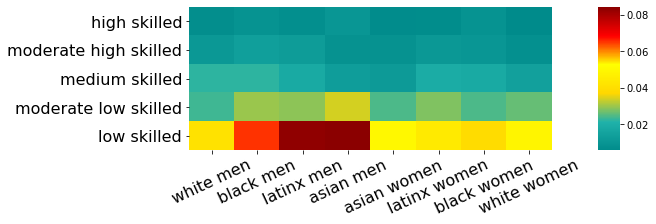

In [161]:
# average job skill change for each race gender group by skill level
df_rg=pd.DataFrame()
gjc=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for cat in ['white men', 'black men', 'latinx men', 'asian men', 'asian women', 'latinx women',
            'black women', 'white women']:
    wwjs=occpar[cat]
    wwgjc=defaultdict(lambda:defaultdict(lambda:0))
    for o in wwjs:
        if o in osn2 and o in jtr2:
            perc = np.ceil(stats.percentileofscore(list(GenderRace['skill#']), osn2[o])/20)
            wwgjc[perc][o]=jtr2[o]
    wwgjc = dict(sorted(wwgjc.items(), key=operator.itemgetter(0), reverse=True))
    gjc[cat]=wwgjc
    df_rg[cat] = [np.median(list(wwgjc[g].values())) for g in list(range(1,6))][::-1]

cmap= matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkcyan",'lightseagreen',"gold",'yellow',"red","darkred"])
#f3_ax2 = fig3.add_subplot(gs[2, :3])
fig3 = plt.figure(figsize=(9,3), constrained_layout=True)
y_axis_labels = ['high skilled', 'moderate high skilled', 'medium skilled', 'moderate low skilled', 'low skilled']
ax = sns.heatmap(df_rg, cbar=True, cmap=cmap, yticklabels=y_axis_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
plt.show()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P4.pdf')